# Image classification task

In [ ]:
!pip install scikit-plot

## Imports

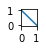

In [ ]:
import numpy as np
import time
import datetime
import pandas as pd
import seaborn as sns
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import matplotlib.pyplot as plt; plt.figure(figsize=(0.3,0.3));plt.plot([1,0]);

In [ ]:
import torchvision
import torch
from torch import nn
from torch.nn.functional import mse_loss
from torch import optim
import tqdm
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Getting the data

In [ ]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


### Defining a Dataset object and DataLoader

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import  SubsetRandomSampler
#num of subprocess to use for data loading
num_workers=0
#how many sampler per batch to load
batch_size=32
#percentage of training set to use as validation
valid_size=0.2

target_transformer = transforms.Compose([lambda x:torch.LongTensor([x]), # or just torch.tensor
                                         lambda x:F.one_hot(x,10)[0] #Transforming the tensor into one hot ([0,1,0,0,0...])
                                         ])
image_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.RandomHorizontalFlip(p=0.5), #In digits it doesn't make any sense.\n",
                                        transforms.RandomVerticalFlip(p=0.5),
])
  
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform)
# test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform)

# Choose the training and test sets
train_data=datasets.CIFAR10('data',train=True,
                           download=True,
                           transform=image_transformer,
                           target_transform=target_transformer)
test_data=datasets.CIFAR10('data',train=False,
                          download=True,
                          transform=transforms.ToTensor(),
                          target_transform=target_transformer)

# Get training indices will be used for validation
num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))
train_idx, valid_idx=indices[split:],indices[:split]

# define samplers
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler= SubsetRandomSampler(valid_idx)

# split train set into training and validation subsets
#train_subset, val_subset = torch.utils.data.random_split(
 #       train, [50000, 10000], generator=torch.Generator().manual_seed(1))

# Combine datasets and samplers
#train_loader = DataLoader(train_data, batch_size= 32)
train_loader= torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                         sampler=train_sampler, num_workers=num_workers)
valid_loader= torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                          sampler=valid_sampler,num_workers=num_workers)
test_loader= torch.utils.data.DataLoader(test_data,batch_size=batch_size,
                                         num_workers=num_workers)

classes1 = train_data.classes
classes = tuple(classes1)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Data Exploration

### Seeing the data in your eyes!

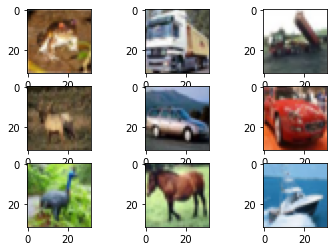

In [ ]:
def sample_some_images_and_plot(X_train, y_train): 
    #It is computer vision data (images), you have the privilage to look it in your eyes.
    for i in range(9):
	    # define subplot
	    plt.subplot(330 + 1 + i)
	    # plot raw pixel data
	    plt.imshow(X_train[i])    
    plt.show()
# using plotting function
sample_some_images_and_plot(X_train, y_train) 

Dimensions of data:
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Reviewing first nine images:


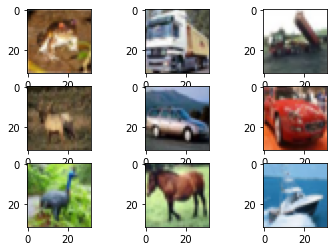

In [ ]:
# Understanding dataset dimensions (without defining func)
print('Dimensions of data:')
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# Plot first nine images
print('Reviewing first nine images:')
for i in range(0,9,1):
	  plt.subplot(330 + 1 + i)
	  plt.imshow(X_train[i])
plt.show()

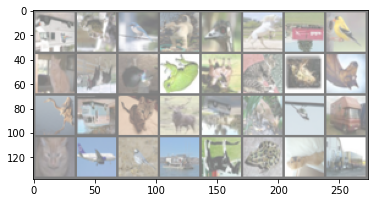

In [ ]:
# More Images - Using our data loaders object
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Random images from train set:
dataiter = iter(train_loader)
#dataiter = iter(valid_loader) # validation imgs
images, labels = dataiter.next()
# print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### More tools to understand the data better
* Label distribution?
* Colors distribution?

**Label distribution**

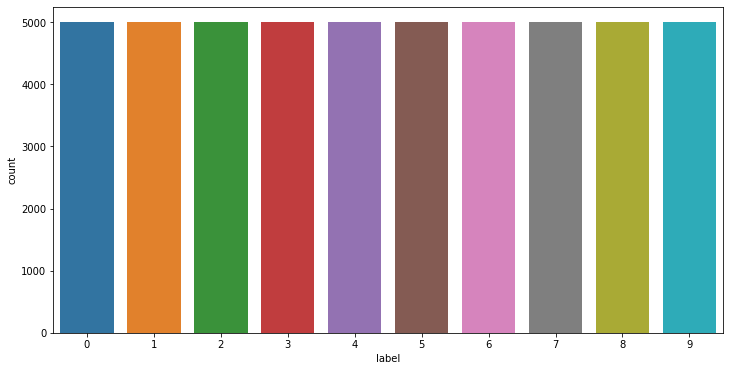

In [ ]:
y_train_df = pd.DataFrame(y_train, columns=['label'])
plt.figure(figsize = (12, 6))
sns.countplot(x='label', data=y_train_df)

All labels are distributed equally.

## Model evaluation tools

The evaluation report will be used to determine how well the model perform

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
import keras.backend as K
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

def evaluation_function1(y_actual, y_pred):
  print("Classification Report: \n", classification_report(y_actual, y_pred))

def confusion_matrix(y_actual, y_pred):
  #Plot the confusion matrix
  print('\n Confusion matrix :')
  plot_confusion_matrix(y_actual, y_pred, normalize=False,figsize=(15,8))


# Printing the accuracy
def Accuracy(y_actual, y_pred):
    print("Accuracy:",metrics.accuracy_score(y_actual, y_pred))

def evaluation_report(y_actual, y_pred):
    Accuracy(y_actual, y_pred)
    print("\n")
    evaluation_function1(y_actual, y_pred)
    print('\n')
    confusion_matrix(y_actual, y_pred)

## Model research

### Baseline model

X_train shape : (50000, 3072)
Accuracy: 0.2686


Classification Report: 
               precision    recall  f1-score   support

           0       0.34      0.36      0.35      1000
           1       0.29      0.28      0.28      1000
           2       0.21      0.22      0.21      1000
           3       0.19      0.20      0.20      1000
           4       0.22      0.22      0.22      1000
           5       0.20      0.20      0.20      1000
           6       0.29      0.28      0.28      1000
           7       0.28      0.27      0.27      1000
           8       0.37      0.39      0.38      1000
           9       0.29      0.28      0.28      1000

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.27     10000
weighted avg       0.27      0.27      0.27     10000




 Confusion matrix :


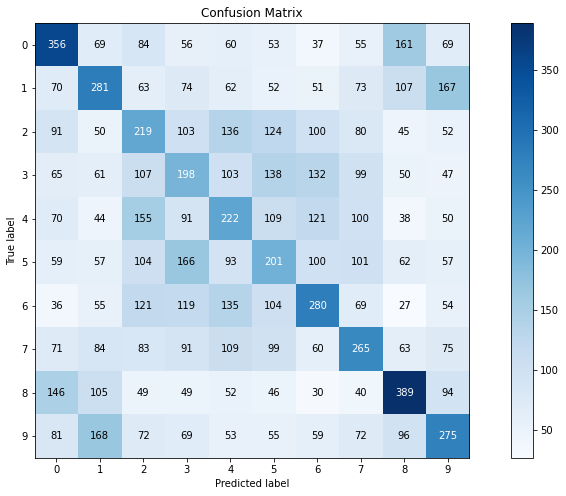

In [ ]:
X_train_baseline = X_train.reshape(X_train.shape[0], -1)
print("X_train shape :", X_train_baseline.shape)
X_test_baseline = X_test.reshape(X_test.shape[0], -1)
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
base_model = DecisionTreeClassifier()

# Train Decision Tree Classifer
base_model = base_model.fit(X_train_baseline,y_train)

#Predict the response for test dataset
y_pred = base_model.predict(X_test_baseline)

# Evaluation report for the baseline model (less informative)
evaluation_report(y_test, y_pred)

**Visualize the predictions for Decision tree**

True label : cat, Predicted label : horse


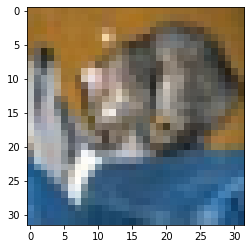

True label : ship, Predicted label : automobile


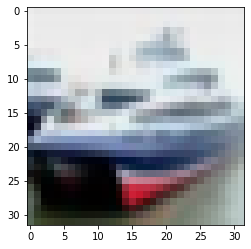

True label : ship, Predicted label : truck


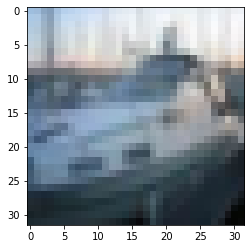

True label : airplane, Predicted label : bird


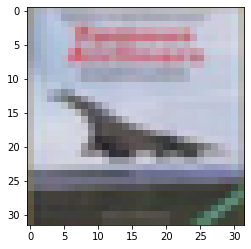

True label : frog, Predicted label : deer


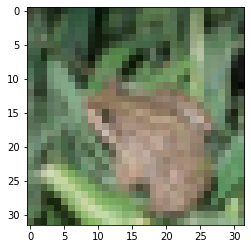

True label : frog, Predicted label : horse


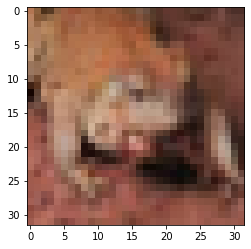

In [ ]:
# Plot 6 images with true & prediction labels
def plot_predictions(X_test, y_test, y_pred):
  # Flattend the y_test array
  y_test = y_test.flatten() 
  for i in range(6):
    # True labels & predictions
    test_index = y_test[i]
    pred_index = y_pred[i]
    print('True label : {}, Predicted label : {}'.format(classes[test_index], classes[pred_index]))
	  # plot raw pixel data
    plt.imshow(X_test[i])    
    plt.show()
# using plotting function
plot_predictions(X_test, y_test, y_pred) 

**Define a function for calculating elapsed time.**

In [ ]:
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

For the object oriented folks - it is strongly suggested to define an "Engine" for the model. <br>
It is a great way to wrap all the moving parts together.

In [ ]:
from torch.autograd import Variable
# Epochs
epochs = 50
class Engine:
    def __init__(self, model, optimizer, loss_function, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device

    def train_validate_epoch(self, train_dataloader, val_dataloader):
      self.model.train()
      
      # Store loss value for each epoch
      loss_values = []
      for epoch in range(0, epochs):
          
              # Perform forward pass over the training dataset
              print("\n ======== Epoch {:}/{:} ========".format(epoch+1,epochs))
              print('Training....')
              
              # Measure how long a epoch takes
              t0 = time.time()
              # Reset total loss  & acc for this epoch
              total_loss = 0
              
              # Put the model in training mode
              self.model.train()
              
              # For each training batch
              for step, batch in enumerate(train_dataloader):
                  # Update progress for 40 steps
                  if (step % 40 ==0) & (not step==0):
                      # Calculate elapsed time in minutes
                      elapsed = format_time((time.time()-t0))
                      # Report progress
                      print(' Batch {:>5,} of {:>5,}. Elapsed:{:}.'.format(step,len(train_dataloader),elapsed))
                  
                  # Unpack training batch from trainloader & move to GPU
                  inputs = batch[0].to(device)  # 0 - inputs
                  labels = batch[1].to(device)     # 1 - labels
                  
                  # Get the 1D target tensor
                  labels = torch.argmax(labels, dim=1)
                  # Clear default gradients accumulated in Pytorch
                  self.model.zero_grad()
                  
                  # Output the results
                  outputs = self.model(inputs) # Return tuple
  
                  # Get loss values
                  loss = self.loss_function(outputs, labels)
              
                  # Update total loss
                  total_loss += loss.item()
                  
                  
                  # Perform a backward pass to calculate gradients
                  loss.backward()
                  
                  # To avoid exploding vanishing gradients problem,clip the norm of the gradients to 1.0
                  torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0)
                  
                  # Update the parameters (weights)
                  optimizer.step()
                  
              # Calculate the average loss over training data
              avg_total_loss = total_loss/len(train_dataloader)
                  
              # Store the loss values
              loss_values.append(avg_total_loss)


              print("")
              
              print('Average training loss : {0:.2f}'.format(avg_total_loss))
              print('Training epoch took: {:}'.format(format_time(time.time()- t0)))
              
              ####### Validation #######
              # After each epoch perform validation to check model performance
              print('\n Running validation...')
              
              t0 = time.time()
              #put model in evaluation mode
              self.model.eval()
              
              # Tracking variables
              correct = 0
              total = 0
              
              # Evaluate val data for each epoch
              for batch in val_dataloader:
                  # Unpack training batch from validation loader & move to GPU
                  inputs = batch[0].to(device)  # 0 - inputs
                  labels = batch[1].to(device)     # 1 - labels

                  # Get the 1D target tensor
                  labels = torch.argmax(labels, dim=1)
                  # Tell model not to compute gradients to save memory & speed up validation
                  with torch.no_grad():
                      # Forward pass, calculate logit prediction
                      outputs = self.model(inputs)
                  # Get predictions from outputs
                  _, preds = torch.max(outputs, 1)

                  total += labels.size(0)
                  correct += (preds == labels).sum().item()

                      
              # Report the final validation accuracy
              print(' Accuracy {0:.2f}'.format(100 * correct / total))
              print(' Validation took : {:}'.format(format_time(time.time() - t0)))
            
            
      print('\n Training completed!')

### Model evaluation

In [ ]:
# Get predictions on test data
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  prediction_probs = []
  true_values = []
  input_values = []

  with torch.no_grad():
    for d in data_loader:
      inputs = d[0].to(device)
      labels = d[1].to(device)

      # Get the 1D target tensor
      labels = torch.argmax(labels, dim=1)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      true_values.extend(labels)
      input_values.extend(inputs)
  
  input_values = torch.stack(input_values).cpu()
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  true_values = torch.stack(true_values).cpu()
  return input_values, predictions, prediction_probs, true_values

In [ ]:
##@title Default title text
#Torch Submoduling
#Number of classes
num_classes= len(classes)
# The cnn arcitecture
class Net(nn.Module):
    def __init__(self,n_neurons,out_neurons ):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3, n_neurons, 5) #nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) #MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_neurons, out_neurons, 5) #Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(out_neurons * 5 * 5, 120) #Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84) #Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  #Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))# וקטור שמציין עבור הנוירון הראשון את כל הבאטצים
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#my_model=Net(6,16)

#n_neurons=32
class CNN(nn.Module):
    def __init__(self,n_neurons,n_layers,dropout_rate=0.3):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=n_neurons, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_neurons),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=n_neurons, out_channels=n_neurons*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #n_neurons=n_neurons*2
      
            # Conv Layer block 2
            nn.Conv2d(in_channels=n_neurons*2, out_channels=n_neurons*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_neurons*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=n_neurons*4, out_channels=n_neurons*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_rate),

            # Conv Layer block 3
            nn.Conv2d(in_channels=n_neurons*4, out_channels=n_neurons*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_neurons*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=n_neurons*8, out_channels=n_neurons*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
         
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(n_neurons*128, n_neurons*n_neurons),
            nn.ReLU(inplace=True),
            nn.Linear(n_neurons*n_neurons, n_neurons*16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(n_neurons*16, 10)
        )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        #print('x_shape:',x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)   
        # fc layer
        x = self.fc_layer(x)
        return x
        
# VGG CNN with 16 layers
class VGG(nn.Module):
    def __init__(self, num_classes, n_neurons):
        super(VGG, self).__init__()
        # group 1
        self.conv1a = nn.Conv2d(3, n_neurons, kernel_size=3, padding=1) #(3, 64, kernel_size=3, padding=1)
        self.conv1a_bn = nn.BatchNorm2d(n_neurons)
        self.conv1b = nn.Conv2d(n_neurons, n_neurons, kernel_size=3, padding=1)
        self.conv1b_bn = nn.BatchNorm2d(n_neurons)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # group 2
        self.conv2a = nn.Conv2d(n_neurons, n_neurons*2, kernel_size=3, padding=1)
        self.conv2a_bn = nn.BatchNorm2d(n_neurons*2)
        self.conv2b = nn.Conv2d(n_neurons*2, n_neurons*2, kernel_size=3, padding=1)
        self.conv2b_bn = nn.BatchNorm2d(n_neurons*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # group 3
        self.conv3a = nn.Conv2d(n_neurons*2, n_neurons*4, kernel_size=3, padding=1)
        self.conv3a_bn = nn.BatchNorm2d(n_neurons*4)
        self.conv3b = nn.Conv2d(n_neurons*4, n_neurons*4, kernel_size=3, padding=1)
        self.conv3b_bn = nn.BatchNorm2d(n_neurons*4)
        self.conv3c = nn.Conv2d(n_neurons*4, n_neurons*4, kernel_size=3, padding=1)
        self.conv3c_bn = nn.BatchNorm2d(n_neurons*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # group 4
        self.conv4a = nn.Conv2d(n_neurons*4, n_neurons*8, kernel_size=3, padding=1)
        self.conv4a_bn = nn.BatchNorm2d( n_neurons*8)
        self.conv4b = nn.Conv2d( n_neurons*8,  n_neurons*8, kernel_size=3, padding=1)
        self.conv4b_bn = nn.BatchNorm2d( n_neurons*8)
        self.conv4c = nn.Conv2d( n_neurons*8,  n_neurons*8, kernel_size=3, padding=1)
        self.conv4c_bn = nn.BatchNorm2d( n_neurons*8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # group 5
        self.conv5a = nn.Conv2d( n_neurons*8,  n_neurons*8, kernel_size=3, padding=1)
        self.conv5a_bn = nn.BatchNorm2d( n_neurons*8)
        self.conv5b = nn.Conv2d( n_neurons*8,  n_neurons*8, kernel_size=3, padding=1)
        self.conv5b_bn = nn.BatchNorm2d( n_neurons*8)
        self.conv5c = nn.Conv2d( n_neurons*8,  n_neurons*8, kernel_size=3, padding=1)
        self.conv5c_bn = nn.BatchNorm2d( n_neurons*8)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=1)

        self.classifier = nn.Linear( n_neurons*8, 10)
        #self.classifier = nn.Linear(512 * 1 * 1, 512)

        self.relu = nn.ReLU()

    def forward(self, x):
        # group 1
        x = self.relu(self.conv1a_bn(self.conv1a(x)))
        x = self.relu(self.conv1b_bn(self.conv1b(x)))
        x = self.pool1(x)
        # group 2
        x = self.relu(self.conv2a_bn(self.conv2a(x)))
        x = self.relu(self.conv2b_bn(self.conv2b(x)))
        x = self.pool2(x)
        # group 3
        x = self.relu(self.conv3a_bn(self.conv3a(x)))
        x = self.relu(self.conv3b_bn(self.conv3b(x)))
        x = self.relu(self.conv3c_bn(self.conv3c(x)))
        x = self.pool3(x)
        # group 4
        x = self.relu(self.conv4a_bn(self.conv4a(x)))
        x = self.relu(self.conv4b_bn(self.conv4b(x)))
        x = self.relu(self.conv4c_bn(self.conv4c(x)))
        x = self.pool4(x)
        # group 5
        x = self.relu(self.conv5a_bn(self.conv5a(x)))
        x = self.relu(self.conv5b_bn(self.conv5b(x)))
        x = self.relu(self.conv5c_bn(self.conv5c(x)))
        x = self.pool5(x)

        x = self.avg_pool(x)
        #print(x.shape)
        #print('x_shape:',x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.classifier(x)
        
        return x

class VGG16_torch(nn.Module):
    def __init__(self):
        super(VGG16_torch,self).__init__()
        # GROUP 1
        self.conv1_1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=(1,1)) #output:32*32*64
        self.conv1_2 = nn.Conv2d(in_channels=64,out_channels=64 ,kernel_size=3,stride=1,padding=(1,1))#output:32*32*64
        self.maxpool1 = nn.MaxPool2d(2)#After pooling, the length and width are halved output:16*16*64

        # GROUP 2
        self.conv2_1 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=(1,1))#output:16*16*128
        self.conv2_2 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=(1,1))#output:16*16*128
        self.maxpool2 = nn.MaxPool2d(2)   #After pooling, the length and width are halved output:8*8*128

        # GROUP 3
        self.conv3_1 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=(1,1))#output:8*8*256
        self.conv3_2 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=(1,1))#output:8*8*256
        self.conv3_3 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1)#output:8*8*256
        self.maxpool3 = nn.MaxPool2d(2)    # After pooling, the length and width are halved output:4*4*256

        # GROUP 4
        self.conv4_1 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)#output:4*4*512
        self.conv4_2 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)#output:4*4*512
        self.conv4_3 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,stride=1)#output:4*4*512
        self.maxpool4 = nn.MaxPool2d(2)    # After pooling, the length and width are halved output:2*2*512

        # GROUP 5
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)  # output:14*14*512
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)  # output:14*14*512
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1)  # output:14*14*512
        self.maxpool5 = nn.MaxPool2d(2)    # After pooling, the length and width are halved output:1*1*512

        self.fc1 = nn.Linear(in_features=512*1*1,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=10)

    #Define forward propagation
    def forward(self,x):
        input_dimen = x.size(0)

        #GROUP 1
        output = self.conv1_1(x)
        output = F.relu(output)
        output = self.conv1_2(output)
        output = F.relu(output)
        output = self.maxpool1(output)

        #GROUP 2
        output = self.conv2_1(output)
        output = F.relu(output)
        output = self.conv2_2(output)
        output = F.relu(output)
        output = self.maxpool2(output)

        #GROUP 3
        output = self.conv3_1(output)
        output = F.relu(output)
        output = self.conv3_2(output)
        output = F.relu(output)
        output = self.conv3_3(output)
        output = F.relu(output)
        output = self.maxpool3(output)

        #GROUP 4
        output = self.conv4_1(output)
        output = F.relu(output)
        output = self.conv4_2(output)
        output = F.relu(output)
        output = self.conv4_3(output)
        output = F.relu(output)
        output = self.maxpool4(output)

        #GROUP 5
        output = self.conv5_1(output)
        output = F.relu(output)
        output = self.conv5_2(output)
        output = F.relu(output)
        output = self.conv5_3(output)
        output = F.relu(output)
        output = self.maxpool5(output)

        #print('x_shape:',output.shape)
        output = output.view(x.size(0),-1)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        
		    #Return to output
        return output


my_model2 = VGG(num_classes=num_classes, n_neurons=64)
# Checks
#print(my_model2)
#from torchsummary import summary
#summary(my_model2,(3, 32, 32))
list(my_model2.parameters())[0].shape

torch.Size([64, 3, 3, 3])

In [ ]:
# Initializing models
Net = Net(6,16)
CNN = CNN(32,3) 
VGG = VGG(10, 64) # num_classes=10, n_neurons = 64
VGG_16 = VGG16_torch()

### Loss function

We are considering the **CrossEntropyLoss()** loss function for **all models**. Cross entropy is used as loss function when optimizing classification models. Using the cross-entropy error function instead of the sum-of-squares for a classification problem leads to faster training as well as improved generalization.

For more details:       
https://machinelearningmastery.com/cross-entropy-for-machine-learning/     
https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

In [ ]:
# Define a loss function & move it to GPU
criterion = nn.CrossEntropyLoss().to(device) # loss

### Training & testing the Net model

In [ ]:
# Move model to GPU
Net = Net.to(device) 

optimizer=optim.Adam(Net.parameters(),lr=1e-3)
engine = Engine(Net, optimizer, criterion, device)
engine.train_validate_epoch(train_loader, valid_loader)


 ======== Epoch 1/50 ========
Training....
 Batch    40 of 1,250. Elapsed:0:00:01.
 Batch    80 of 1,250. Elapsed:0:00:01.
 Batch   120 of 1,250. Elapsed:0:00:02.
 Batch   160 of 1,250. Elapsed:0:00:02.
 Batch   200 of 1,250. Elapsed:0:00:03.
 Batch   240 of 1,250. Elapsed:0:00:03.
 Batch   280 of 1,250. Elapsed:0:00:04.
 Batch   320 of 1,250. Elapsed:0:00:04.
 Batch   360 of 1,250. Elapsed:0:00:05.
 Batch   400 of 1,250. Elapsed:0:00:05.
 Batch   440 of 1,250. Elapsed:0:00:05.
 Batch   480 of 1,250. Elapsed:0:00:06.
 Batch   520 of 1,250. Elapsed:0:00:06.
 Batch   560 of 1,250. Elapsed:0:00:07.
 Batch   600 of 1,250. Elapsed:0:00:07.
 Batch   640 of 1,250. Elapsed:0:00:08.
 Batch   680 of 1,250. Elapsed:0:00:08.
 Batch   720 of 1,250. Elapsed:0:00:09.
 Batch   760 of 1,250. Elapsed:0:00:09.
 Batch   800 of 1,250. Elapsed:0:00:10.
 Batch   840 of 1,250. Elapsed:0:00:10.
 Batch   880 of 1,250. Elapsed:0:00:11.
 Batch   920 of 1,250. Elapsed:0:00:11.
 Batch   960 of 1,250. Elapsed:0:00:

In [ ]:
# Get predictions on test data
inputs, predictions, prediction_probs, true_values = get_predictions(Net, test_loader)
# Convert to numpy
x_test = inputs.detach().to('cpu').numpy()
y_pred = predictions.to('cpu').numpy()
y_actual = true_values.to('cpu').numpy()

Accuracy: 0.5979


Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.61      0.65      1000
           1       0.72      0.70      0.71      1000
           2       0.54      0.45      0.49      1000
           3       0.40      0.32      0.36      1000
           4       0.47      0.60      0.53      1000
           5       0.48      0.52      0.50      1000
           6       0.65      0.71      0.68      1000
           7       0.71      0.59      0.64      1000
           8       0.68      0.78      0.73      1000
           9       0.63      0.69      0.66      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000




 Confusion matrix :


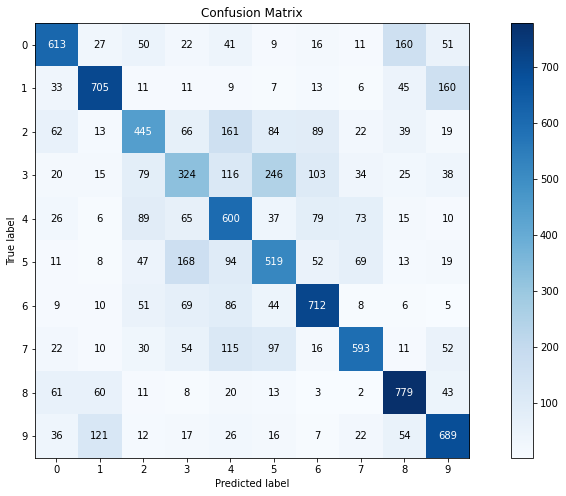

In [ ]:
# Evaluation report
evaluation_report(y_actual, y_pred)

**Visualize predictions for Net model**

In [ ]:
# Plot 6 images with true & prediction labels
def plot_predictions_nn(X_test, y_test, y_pred):
  # Flattend the y_test array
  y_test = y_test.flatten() 
  for i in range(6):
    # True labels & predictions
    test_index = y_test[i]
    pred_index = y_pred[i]
    print('True label : {}, Predicted label : {}'.format(classes[test_index], classes[pred_index]))
	  # plot raw pixel data
    plt.imshow(np.transpose(X_test[i], (1, 2, 0)))    
    plt.show()

True label : cat, Predicted label : cat


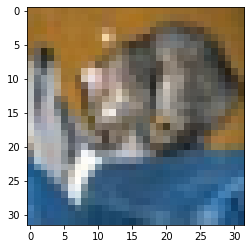

True label : ship, Predicted label : ship


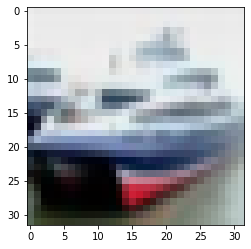

True label : ship, Predicted label : automobile


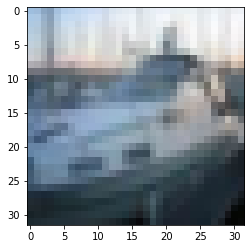

True label : airplane, Predicted label : airplane


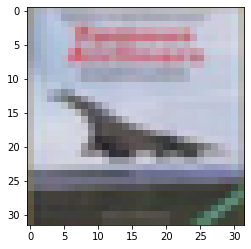

True label : frog, Predicted label : frog


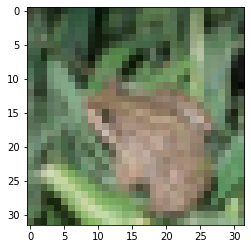

True label : frog, Predicted label : frog


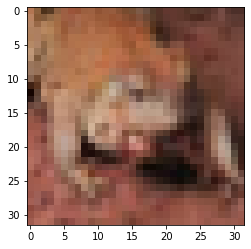

In [ ]:
# Net
plot_predictions_nn(x_test, y_actual, y_pred)

Let’s quickly save our trained model:

In [ ]:
PATH = './cifar_Net.pth'
torch.save(Net.state_dict(), PATH)

### Training & testing the CNN model

In [ ]:
# Move model to GPU
CNN = CNN.to(device) 

optimizer=optim.Adam(CNN.parameters(),lr=1e-4)
engine = Engine(CNN, optimizer, criterion, device)
engine.train_validate_epoch(train_loader, valid_loader)


 ======== Epoch 1/50 ========
Training....
 Batch    40 of 1,250. Elapsed:0:00:01.
 Batch    80 of 1,250. Elapsed:0:00:02.
 Batch   120 of 1,250. Elapsed:0:00:02.
 Batch   160 of 1,250. Elapsed:0:00:03.
 Batch   200 of 1,250. Elapsed:0:00:04.
 Batch   240 of 1,250. Elapsed:0:00:05.
 Batch   280 of 1,250. Elapsed:0:00:05.
 Batch   320 of 1,250. Elapsed:0:00:06.
 Batch   360 of 1,250. Elapsed:0:00:07.
 Batch   400 of 1,250. Elapsed:0:00:08.
 Batch   440 of 1,250. Elapsed:0:00:08.
 Batch   480 of 1,250. Elapsed:0:00:09.
 Batch   520 of 1,250. Elapsed:0:00:10.
 Batch   560 of 1,250. Elapsed:0:00:11.
 Batch   600 of 1,250. Elapsed:0:00:11.
 Batch   640 of 1,250. Elapsed:0:00:12.
 Batch   680 of 1,250. Elapsed:0:00:13.
 Batch   720 of 1,250. Elapsed:0:00:14.
 Batch   760 of 1,250. Elapsed:0:00:14.
 Batch   800 of 1,250. Elapsed:0:00:15.
 Batch   840 of 1,250. Elapsed:0:00:16.
 Batch   880 of 1,250. Elapsed:0:00:17.
 Batch   920 of 1,250. Elapsed:0:00:17.
 Batch   960 of 1,250. Elapsed:0:00:

In [ ]:
# Get predictions on test data
inputs, predictions, prediction_probs, true_values = get_predictions(CNN, test_loader)
# Convert to numpy
x_test = inputs.detach().to('cpu').numpy()
y_pred = predictions.to('cpu').numpy()
y_actual = true_values.to('cpu').numpy()

Accuracy: 0.8533


Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       0.94      0.93      0.93      1000
           2       0.82      0.80      0.81      1000
           3       0.67      0.68      0.67      1000
           4       0.86      0.84      0.85      1000
           5       0.77      0.78      0.77      1000
           6       0.87      0.89      0.88      1000
           7       0.89      0.87      0.88      1000
           8       0.94      0.94      0.94      1000
           9       0.90      0.93      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000




 Confusion matrix :


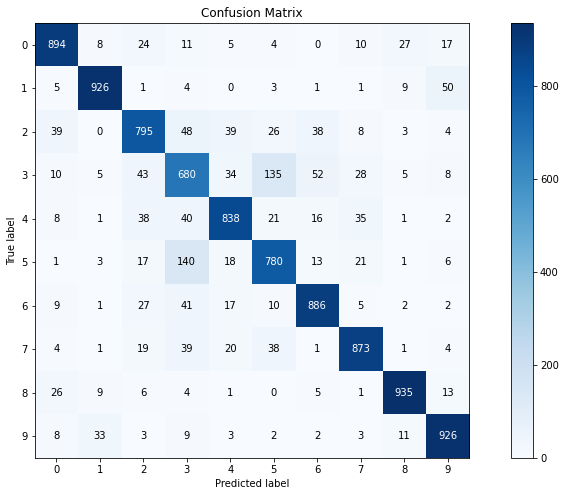

In [ ]:
# Evaluation report
evaluation_report(y_actual, y_pred)

**Visualize predictions for CNN model**

True label : cat, Predicted label : cat


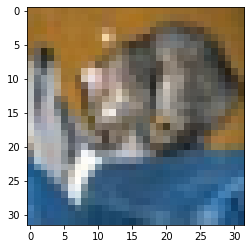

True label : ship, Predicted label : ship


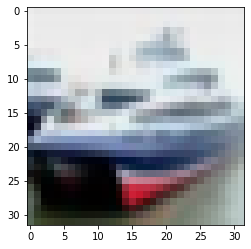

True label : ship, Predicted label : ship


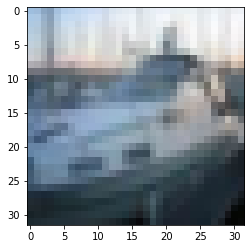

True label : airplane, Predicted label : airplane


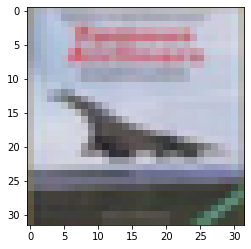

True label : frog, Predicted label : frog


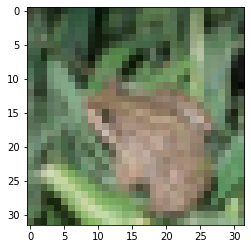

True label : frog, Predicted label : frog


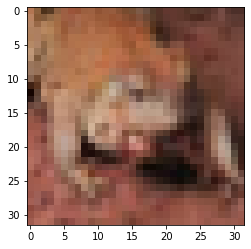

In [ ]:
# CNN
plot_predictions_nn(x_test, y_actual, y_pred)

Let’s quickly save our trained model:

In [ ]:
PATH = './cifar_CNN.pth'
torch.save(CNN.state_dict(), PATH)

### Training & testing the VGG model

In [ ]:
# Move model to GPU
VGG = VGG.to(device) 

optimizer=optim.Adam(VGG.parameters(),lr=1e-4)
engine = Engine(VGG, optimizer, criterion, device)
engine.train_validate_epoch(train_loader, valid_loader)


 ======== Epoch 1/50 ========
Training....
 Batch    40 of 1,250. Elapsed:0:00:02.
 Batch    80 of 1,250. Elapsed:0:00:03.
 Batch   120 of 1,250. Elapsed:0:00:04.
 Batch   160 of 1,250. Elapsed:0:00:06.
 Batch   200 of 1,250. Elapsed:0:00:07.
 Batch   240 of 1,250. Elapsed:0:00:09.
 Batch   280 of 1,250. Elapsed:0:00:10.
 Batch   320 of 1,250. Elapsed:0:00:11.
 Batch   360 of 1,250. Elapsed:0:00:13.
 Batch   400 of 1,250. Elapsed:0:00:14.
 Batch   440 of 1,250. Elapsed:0:00:16.
 Batch   480 of 1,250. Elapsed:0:00:17.
 Batch   520 of 1,250. Elapsed:0:00:18.
 Batch   560 of 1,250. Elapsed:0:00:20.
 Batch   600 of 1,250. Elapsed:0:00:21.
 Batch   640 of 1,250. Elapsed:0:00:23.
 Batch   680 of 1,250. Elapsed:0:00:24.
 Batch   720 of 1,250. Elapsed:0:00:25.
 Batch   760 of 1,250. Elapsed:0:00:27.
 Batch   800 of 1,250. Elapsed:0:00:28.
 Batch   840 of 1,250. Elapsed:0:00:30.
 Batch   880 of 1,250. Elapsed:0:00:31.
 Batch   920 of 1,250. Elapsed:0:00:32.
 Batch   960 of 1,250. Elapsed:0:00:

In [ ]:
# Get predictions on test data
inputs, predictions, prediction_probs, true_values = get_predictions(VGG, test_loader)
# Convert to numpy
x_test = inputs.detach().to('cpu').numpy()
y_pred = predictions.to('cpu').numpy()
y_actual = true_values.to('cpu').numpy()

Accuracy: 0.8549


Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      1000
           1       0.92      0.93      0.92      1000
           2       0.85      0.74      0.80      1000
           3       0.70      0.76      0.73      1000
           4       0.77      0.91      0.83      1000
           5       0.80      0.76      0.78      1000
           6       0.90      0.91      0.91      1000
           7       0.94      0.82      0.88      1000
           8       0.89      0.94      0.92      1000
           9       0.92      0.91      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000




 Confusion matrix :


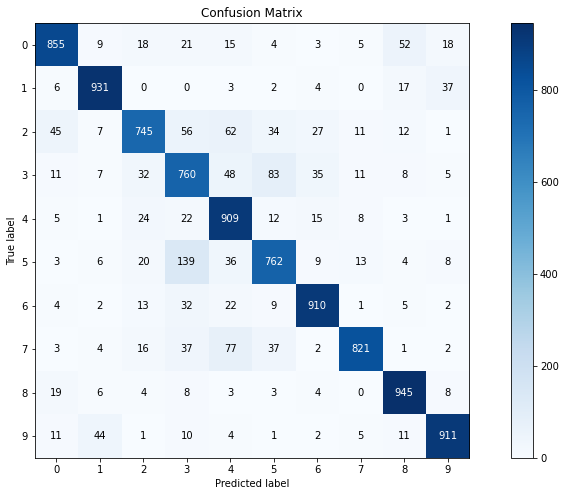

In [ ]:
# Evaluation report
evaluation_report(y_actual, y_pred)

**Visualize predictions for VGG model**

True label : cat, Predicted label : cat


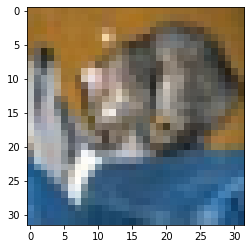

True label : ship, Predicted label : ship


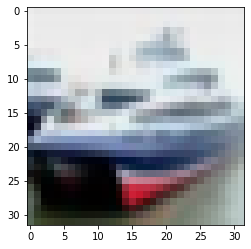

True label : ship, Predicted label : ship


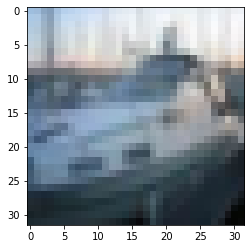

True label : airplane, Predicted label : airplane


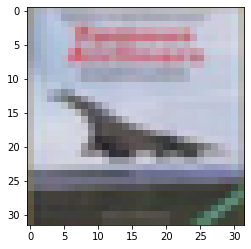

True label : frog, Predicted label : frog


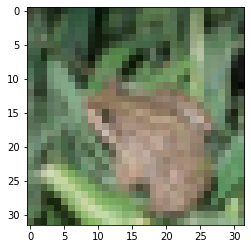

True label : frog, Predicted label : frog


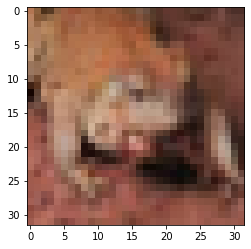

In [ ]:
# VGG
plot_predictions_nn(x_test, y_actual, y_pred)

Let’s quickly save our trained model:

In [ ]:
PATH = './cifar_VGG.pth'
torch.save(VGG.state_dict(), PATH)

### Training & testing the VGG_16 model

In [ ]:
# Move model to GPU
VGG_16 = VGG_16.to(device) 

optimizer=optim.Adam(VGG_16.parameters(),lr=1e-4)
engine = Engine(VGG_16, optimizer, criterion, device)
engine.train_validate_epoch(train_loader, valid_loader)


 ======== Epoch 1/50 ========
Training....
 Batch    40 of 1,250. Elapsed:0:00:01.
 Batch    80 of 1,250. Elapsed:0:00:02.
 Batch   120 of 1,250. Elapsed:0:00:03.
 Batch   160 of 1,250. Elapsed:0:00:05.
 Batch   200 of 1,250. Elapsed:0:00:06.
 Batch   240 of 1,250. Elapsed:0:00:07.
 Batch   280 of 1,250. Elapsed:0:00:08.
 Batch   320 of 1,250. Elapsed:0:00:09.
 Batch   360 of 1,250. Elapsed:0:00:10.
 Batch   400 of 1,250. Elapsed:0:00:11.
 Batch   440 of 1,250. Elapsed:0:00:12.
 Batch   480 of 1,250. Elapsed:0:00:13.
 Batch   520 of 1,250. Elapsed:0:00:14.
 Batch   560 of 1,250. Elapsed:0:00:16.
 Batch   600 of 1,250. Elapsed:0:00:17.
 Batch   640 of 1,250. Elapsed:0:00:18.
 Batch   680 of 1,250. Elapsed:0:00:19.
 Batch   720 of 1,250. Elapsed:0:00:20.
 Batch   760 of 1,250. Elapsed:0:00:21.
 Batch   800 of 1,250. Elapsed:0:00:22.
 Batch   840 of 1,250. Elapsed:0:00:23.
 Batch   880 of 1,250. Elapsed:0:00:24.
 Batch   920 of 1,250. Elapsed:0:00:26.
 Batch   960 of 1,250. Elapsed:0:00:

In [ ]:
# Get predictions on test data
inputs, predictions, prediction_probs, true_values = get_predictions(VGG_16, test_loader)
# Convert to numpy
x_test = inputs.detach().to('cpu').numpy()
y_pred = predictions.to('cpu').numpy()
y_actual = true_values.to('cpu').numpy()

Accuracy: 0.7883


Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.91      0.90      0.90      1000
           2       0.65      0.78      0.71      1000
           3       0.55      0.72      0.63      1000
           4       0.85      0.66      0.74      1000
           5       0.81      0.64      0.71      1000
           6       0.91      0.78      0.84      1000
           7       0.88      0.75      0.81      1000
           8       0.86      0.89      0.87      1000
           9       0.86      0.90      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000




 Confusion matrix :


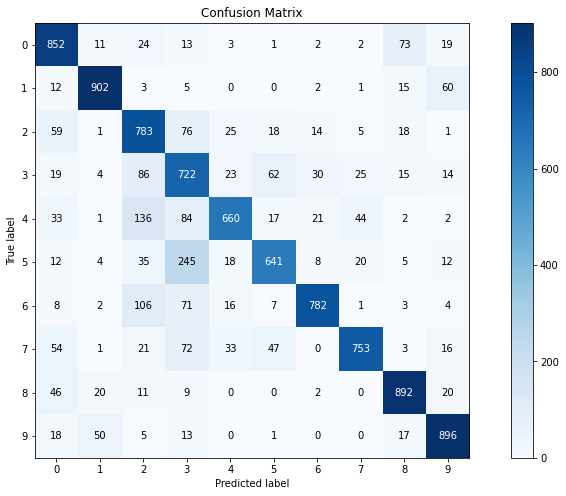

In [ ]:
# Evaluation report
evaluation_report(y_actual, y_pred)

**Visualize predictions for VGG_16**

True label : cat, Predicted label : cat


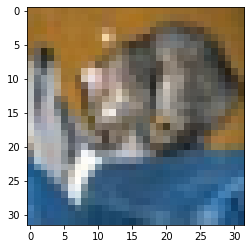

True label : ship, Predicted label : ship


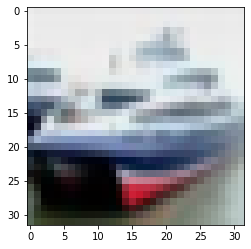

True label : ship, Predicted label : ship


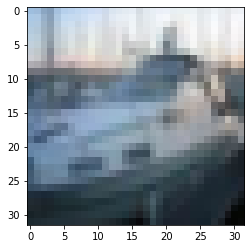

True label : airplane, Predicted label : airplane


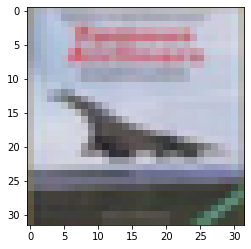

True label : frog, Predicted label : frog


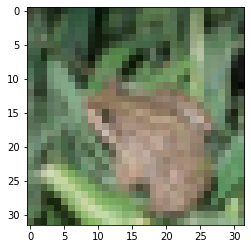

True label : frog, Predicted label : frog


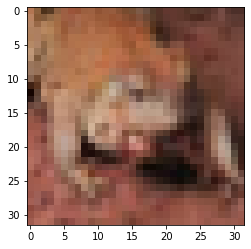

In [ ]:
# VGG_16
plot_predictions_nn(x_test, y_actual, y_pred)

Let’s quickly save our trained model:

In [ ]:
PATH = './cifar_VGG_16.pth'
torch.save(VGG_16.state_dict(), PATH)

### Models performance

In [ ]:
Results={
    'Model':['Base model(DT)','Net','CNN','VGG','VGG_16'],
    'f1-score(weighted)':[0.27, 0.60, 0.85, 0.85, 0.79],                # f1-score is weighted average
    'Accuracy':[0.27, 0.60, 0.85, 0.85, 0.79]                           # Accuracy
      }                              

results_df=pd.DataFrame(Results)
results_df = results_df.sort_values(by = ['f1-score(weighted)'], ascending=False).reset_index(drop=True)
results_df.index+=1
results_df

,Model,f1-score(weighted),Accuracy
1,CNN,0.85,0.85
2,VGG,0.85,0.85
3,VGG_16,0.79,0.79
4,Net,0.60,0.60
5,Base model(DT),0.27,0.27


Insights:
* Both CNN & VGG model is performing well amomg all with an accuracy of 0.85, & f1-score of 0.85.
* All the models having difficulty in predicting class 3 (cat) correctly due to low precision & recall.
* Models performance can be improved further by increasing the number of epochs.

Let's see the architecture of best models:

### CNN model architecture

In [ ]:
print(CNN)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.3, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

Details:
* Two sequential layers are defined for conv_layer & fc_layer (fully connected) respectively.
* conv_layer contains 6 conv2d layers, 3 BatchNorm2d layers, 6 ReLU activation layers, 3 MaxPool2d layers, & a Dropout layer.
* fc_layer contains 3 Linear layers, 2 ReLU activation layers, & 2 Dropout layers.

### VGG model architecture

In [ ]:
print(VGG)

VGG(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1a_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a_bn): BatchNorm2d(256, eps=1e-05, mome

Details:
* VGG contains 13 Conv2d layers, 13 BatchNorm2d layers, 5 MaxPool2d layers, 1 AvgPool2d layer, 1 Linear/classifier, & a ReLU activation layer.